In [49]:
import os
import sys
import numpy as np
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import pyrender
import trimesh
import matplotlib.pyplot as plt

INFO - 2022-02-09 22:38:45,769 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [50]:
import pyglet
pyglet.options['shadow_window'] = False
import os
import numpy as np
import trimesh

from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     Viewer, OffscreenRenderer, RenderFlags

#==============================================================================
# Mesh creation
#==============================================================================

#------------------------------------------------------------------------------
# Creating textured meshes from trimeshes
#------------------------------------------------------------------------------




In [51]:
mesh = trimesh.load("/scratch/aiscience/data/synthetic/test/face_mesh/cheeks_in.000001.obj")



In [52]:
mesh = trimesh.load("/scratch/aiscience/data/synthetic/test/face_mesh/cheeks_in.000001.obj")

#f = mesh.faces
#c = mesh.visual.vertex_colors
#mask = np.all(c==[255, 255, 255, 255], axis=1)
#c[mask] = [128, 0, 0, 255]
#mask = np.all(c==[255, 255, 0, 255], axis=1)
#c[mask] = [0, 128, 0, 255]
#mesh.visual.vertex_colors = c
fx = 384.71198 * 8
fy = 384.71198 * 8

W, H = 504*8, 378*8

def initialize_render(m, p, fx, fy):
    scene = trimesh.scene.Scene()
    scene.add_geometry(m)
    camera = scene.camera
    transform = scene.camera_transform

    # Create pyrender scene
    pyrender_scene = pyrender.Scene.from_trimesh_scene(scene)
    scene.camera.K[0, 0] = fx
    scene.camera.K[1, 1] = fy
    scene.camera.K[0, 2] = W / 2
    scene.camera.K[1, 2] = H / 2
    cx = W / 2 #scene.camera.K[0, 2]
    cy = H / 2 #scene.camera.K[1, 2]
    zfar = scene.camera.z_far
    znear = scene.camera.z_near
    cam = pyrender.IntrinsicsCamera(fx, fy, cx, cy, znear, zfar)
    cam_node = pyrender_scene.add(cam, pose=p)
    dl = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=3.0)
    pl = pyrender.PointLight(color=[3.0, 3.0, 3.0], intensity=4.0)
    pl2 = pyrender.PointLight(color=[-3.0, -3.0, 3.0], intensity=2.0)
    pyrender_scene.add(pl)
    pyrender_scene.add(pl2)
    renderer = pyrender.offscreen.OffscreenRenderer(W, H)
    return renderer, pyrender_scene, cam_node


def initialize_example_renderer(fx, fy):
    examples_path = "/home/saurabh.nair/giant_nerfs/pyrender/examples"
    # Fuze trimesh
    fuze_trimesh = trimesh.load(os.path.join(examples_path, './models/fuze.obj'))
    fuze_mesh = Mesh.from_trimesh(fuze_trimesh)

    # Drill trimesh
    drill_trimesh = trimesh.load(os.path.join(examples_path, './models/drill.obj'))
    drill_mesh = Mesh.from_trimesh(drill_trimesh)
    drill_pose = np.eye(4)
    drill_pose[0,3] = 0.1
    drill_pose[2,3] = -np.min(drill_trimesh.vertices[:,2])

    # Wood trimesh
    wood_trimesh = trimesh.load(os.path.join(examples_path, './models/wood.obj'))
    wood_mesh = Mesh.from_trimesh(wood_trimesh)

    # Water bottle trimesh
    bottle_gltf = trimesh.load(os.path.join(examples_path,'./models/WaterBottle.glb'))
    bottle_trimesh = bottle_gltf.geometry[list(bottle_gltf.geometry.keys())[0]]
    bottle_mesh = Mesh.from_trimesh(bottle_trimesh)
    bottle_pose = np.array([
        [1.0, 0.0,  0.0, 0.1],
        [0.0, 0.0, -1.0, -0.16],
        [0.0, 1.0,  0.0, 0.13],
        [0.0, 0.0,  0.0, 1.0],
    ])

    #------------------------------------------------------------------------------
    # Creating meshes with per-vertex colors
    #------------------------------------------------------------------------------
    boxv_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
    boxv_vertex_colors = np.random.uniform(size=(boxv_trimesh.vertices.shape))
    boxv_trimesh.visual.vertex_colors = boxv_vertex_colors
    boxv_mesh = Mesh.from_trimesh(boxv_trimesh, smooth=False)

    #------------------------------------------------------------------------------
    # Creating meshes with per-face colors
    #------------------------------------------------------------------------------
    boxf_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
    boxf_face_colors = np.random.uniform(size=boxf_trimesh.faces.shape)
    boxf_trimesh.visual.face_colors = boxf_face_colors
    boxf_mesh = Mesh.from_trimesh(boxf_trimesh, smooth=False)

    #------------------------------------------------------------------------------
    # Creating meshes from point clouds
    #------------------------------------------------------------------------------
    points = trimesh.creation.icosphere(radius=0.05).vertices
    point_colors = np.random.uniform(size=points.shape)
    points_mesh = Mesh.from_points(points, colors=point_colors)

    #==============================================================================
    # Light creation
    #==============================================================================

    direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
    spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                       innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
    point_l = PointLight(color=np.ones(3), intensity=10.0)


    #==============================================================================
    # Scene creation
    #==============================================================================

    scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))
    #------------------------------------------------------------------------------
    # By manually creating nodes
    #------------------------------------------------------------------------------
    fuze_node = Node(mesh=fuze_mesh, translation=np.array([0.1, 0.15, -np.min(fuze_trimesh.vertices[:,2])]))
    scene.add_node(fuze_node)
    boxv_node = Node(mesh=boxv_mesh, translation=np.array([-0.1, 0.10, 0.05]))
    scene.add_node(boxv_node)
    boxf_node = Node(mesh=boxf_mesh, translation=np.array([-0.1, -0.10, 0.05]))
    scene.add_node(boxf_node)

    #------------------------------------------------------------------------------
    # By using the add() utility function
    #------------------------------------------------------------------------------
    drill_node = scene.add(drill_mesh, pose=drill_pose)
    bottle_node = scene.add(bottle_mesh, pose=bottle_pose)
    wood_node = scene.add(wood_mesh)
    cam_pose = np.array([
        [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
        [1.0, 0.0,           0.0,           0.0],
        [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
        [0.0,  0.0,           0.0,          1.0]
    ])
    direc_l_node = scene.add(direc_l, pose=cam_pose)
    spot_l_node = scene.add(spot_l, pose=cam_pose)
    
    
    
    #==============================================================================
    # Camera creation
    #==============================================================================
    #scene.camera.K[0, 0] = fx
    #scene.camera.K[1, 1] = fy
    #scene.camera.K[0, 2] = W / 2
    #scene.camera.K[1, 2] = H / 2
    cx = W / 2 #scene.camera.K[0, 2]
    cy = H / 2 #scene.camera.K[1, 2]
    #zfar = scene.camera.z_far
    #znear = scene.camera.z_near
    cam = pyrender.IntrinsicsCamera(fx, fy, cx, cy)

    cam_node = scene.add(cam, pose=cam_pose)
    renderer = pyrender.offscreen.OffscreenRenderer(W, H)
    return renderer, scene, cam_node


def initialize_mock_renderer(fx, fy):
    #------------------------------------------------------------------------------
    # Creating meshes with per-face colors
    #------------------------------------------------------------------------------
    cam_pose = np.array([
        [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
        [1.0, 0.0,           0.0,           0.0],
        [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
        [0.0,  0.0,           0.0,          1.0]
    ])
    sphere_trimesh = trimesh.creation.icosphere(radius=0.1, color=np.array([0.0, 0.0, 200]))
    sphere_mesh = Mesh.from_trimesh(sphere_trimesh, smooth=False)
    #=============================================================================
    # Light creation
    #==============================================================================

    direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
    spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                       innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
    point_l = PointLight(color=np.ones(3), intensity=10.0)


    #==============================================================================
    # Scene creation
    #==============================================================================

    scene = Scene(ambient_light=np.array([0.1, 0.1, 0.1, 1.0]))

    sphere_node = Node(mesh=sphere_mesh, translation=np.array([0.0, 0.0, 0.0]))
    scene.add_node(sphere_node)
    direc_l_node = scene.add(direc_l, pose=cam_pose)
    spot_l_node = scene.add(spot_l, pose=cam_pose)
    #==============================================================================
    # Camera creation
    #==============================================================================
    #scene.camera.K[0, 0] = fx
    #scene.camera.K[1, 1] = fy
    #scene.camera.K[0, 2] = W / 2
    #scene.camera.K[1, 2] = H / 2
    cx = W / 2 #scene.camera.K[0, 2]
    cy = H / 2 #scene.camera.K[1, 2]
    #zfar = scene.camera.z_far
    #znear = scene.camera.z_near
    cam = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
    print(cam.fx, cam.fy)

    cam_node = scene.add(cam, pose=cam_pose)
    renderer = pyrender.offscreen.OffscreenRenderer(W, H)
    return renderer, scene, cam_node


def get_mesh_img(renderer, pyrender_scene, cam_node, pose):
    pyrender_scene.set_pose(cam_node, pose=pose)
    rendered_image, depth = renderer.render(pyrender_scene)
    return rendered_image, depth

In [63]:
import numpy as np


def get_spherical_translations(
    radius=0.1, 
    altitude_min=0.0, 
    altitude_max=60.0,
    azimuth_min=0.0, 
    azimuth_max=60, 
    azimuth_discretization=10.0, 
    altitude_discretization=10.0,
):
    azimuth_range = np.arange(
        azimuth_min, azimuth_max, azimuth_discretization
    )
    altitude_range = np.arange(
        altitude_min, altitude_max, altitude_discretization
    )
    translations = []
    for azimuth in azimuth_range:
        for altitude in altitude_range:
            x = radius * \
            np.cos(np.radians(altitude)) \
            * np.cos(np.radians(azimuth))
            y = radius * \
            np.cos(np.radians(altitude)) \
            * np.sin(np.radians(azimuth))
            z = radius * \
            np.sin(np.radians(altitude))
            translations.append([x, y, z])
            
    return translations


def get_spherical_poses(
    radius=0.1, 
    altitude_min=0.0, 
    altitude_max=60.0,
    azimuth_min=0.0, 
    azimuth_max=120., 
    azimuth_discretization=20.0, 
    altitude_discretization=20.0

):
    """Get poses from a sphere where the z points to the origin.
    
    Args:
        translations: List of translation sampled from a sphere.
    
    Return:
        List of pose matrices sampled from a 
        sphere where the "z" of the pose is pointing to origin
        
    """
    translations = get_spherical_translations(
        radius=radius, 
        altitude_min=altitude_min, 
        altitude_max=altitude_max,
        azimuth_min=azimuth_min, 
        azimuth_max=azimuth_max, 
        azimuth_discretization=azimuth_discretization, 
        altitude_discretization=altitude_discretization
    )
    # Gravity vector is arbitrary. Can be any vector
    gravity_vec = [0, 0, 1]
    
    poses = []
    for translation in translations:
        # Negative sign because the "z" points to the origin of the scene. 
        z_vec = np.array(translation) / np.linalg.norm(translation)
        if np.isclose(z_vec.dot(gravity_vec), 1.0, atol=1e-04):
            z_orthogonal_vector = np.cross(z_vec, [1.0, 0.0, 0.0])
        else:
            z_orthogonal_vector = np.cross(z_vec, gravity_vec)
        #x_vec = np.cross(z_vec, z_orthogonal_vector)
        x_vec = z_orthogonal_vector
        y_vec = np.cross(z_vec, x_vec)
        pose_matrix = np.eye(4)
        pose_matrix[:3, 0] = (x_vec / np.linalg.norm(x_vec)).T 
        pose_matrix[:3, 1] = (y_vec / np.linalg.norm(y_vec)).T 
        pose_matrix[:3, 2] = (z_vec / np.linalg.norm(z_vec)).T  
        pose_matrix[:3, 3] = np.array(translation).T
        #rotation_matrix = pose_matrix[:3, :3], rotation_matrix = pose_matrix[:3, :3]
        poses.append(pose_matrix)
    return poses

### 

In [64]:
import yaml
from PIL import Image

data_save_dir = "/scratch/aiscience/data/synthetic/mock_box"
if not os.path.exists(data_save_dir):
    os.mkdir(data_save_dir)
    
renderer, pyrender_scene, cam_node = initialize_mock_renderer(fx, fy)

3077.69584 3077.69584


/tmp/ipykernel_150/820518429.py:42: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Saving to /scratch/aiscience/data/synthetic/mock_box/scene_info.yaml


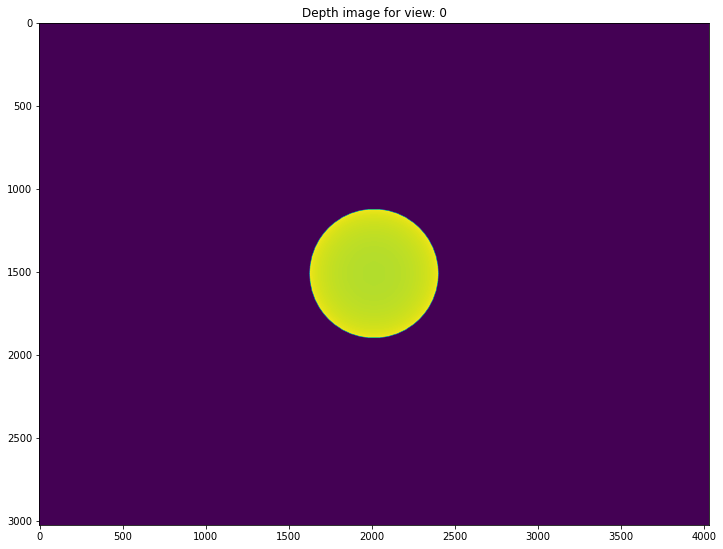

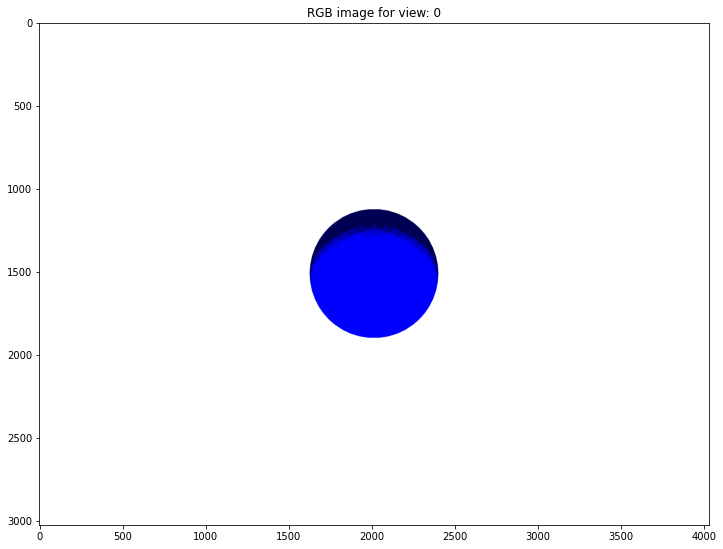

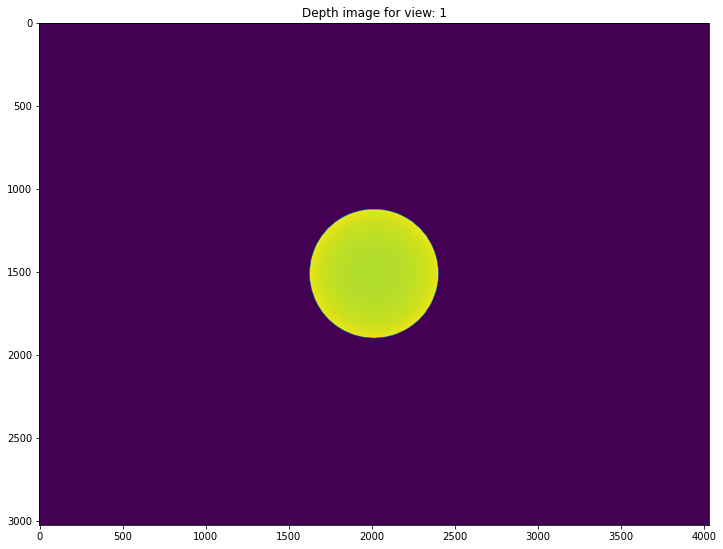

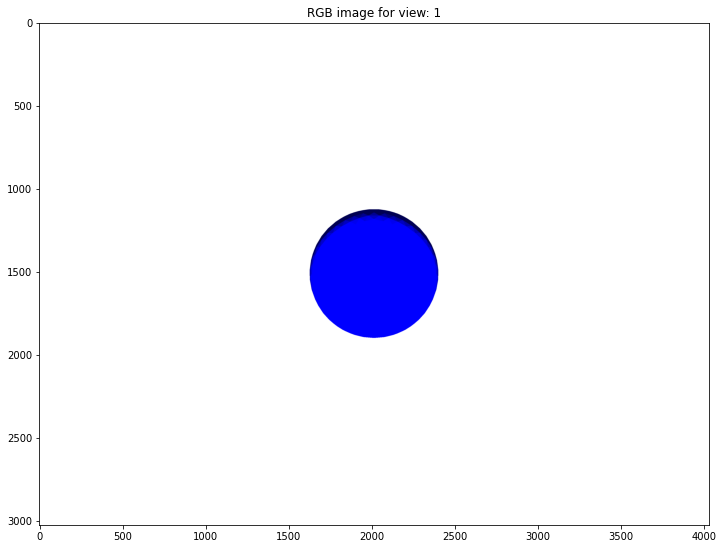

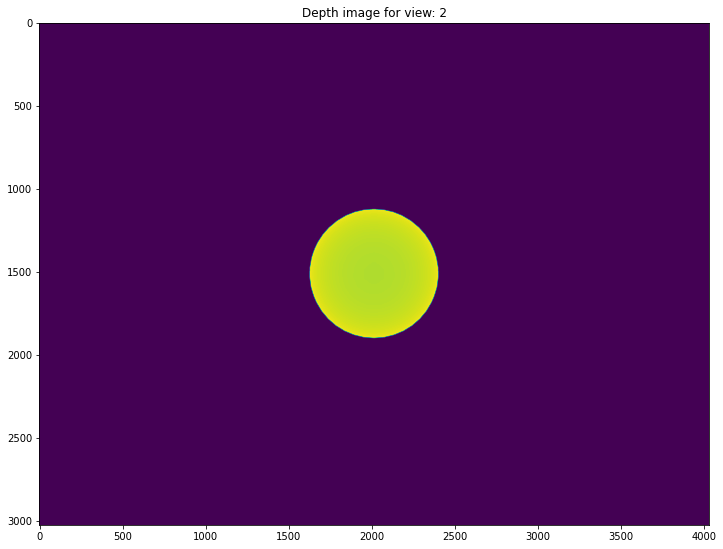

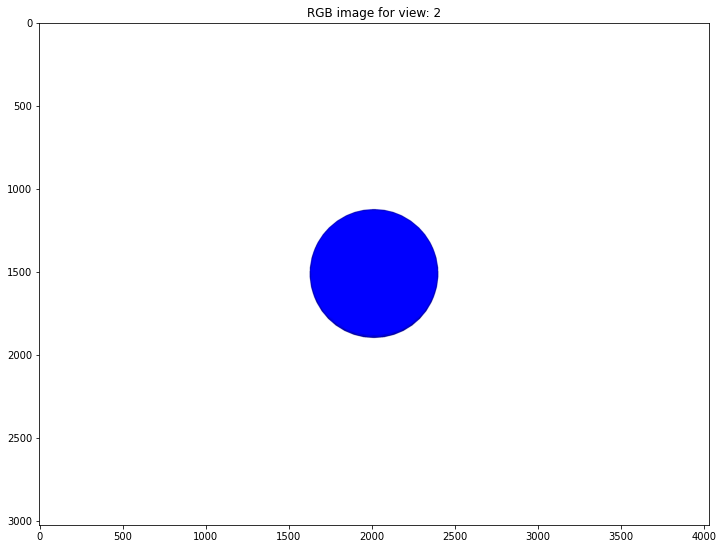

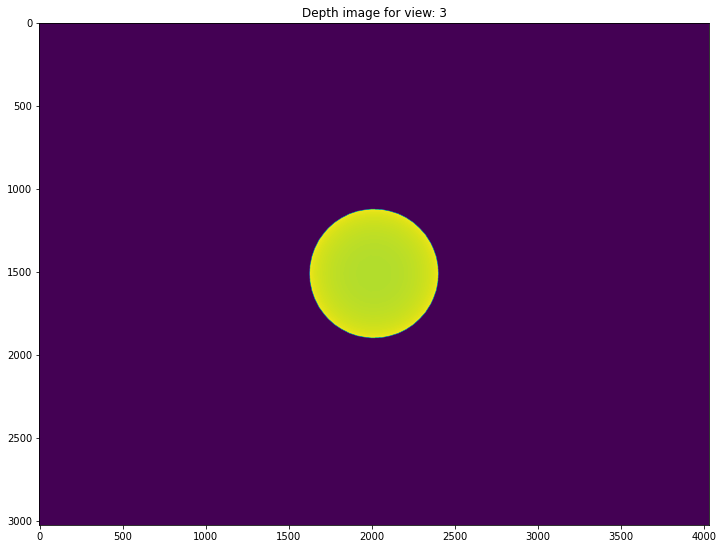

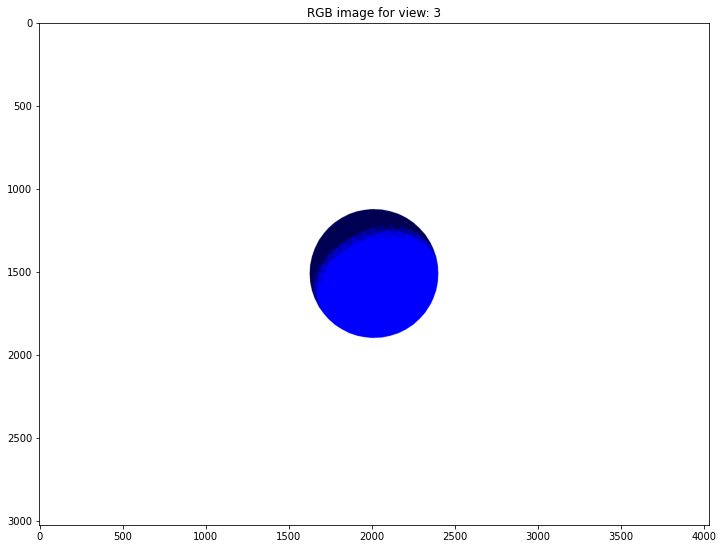

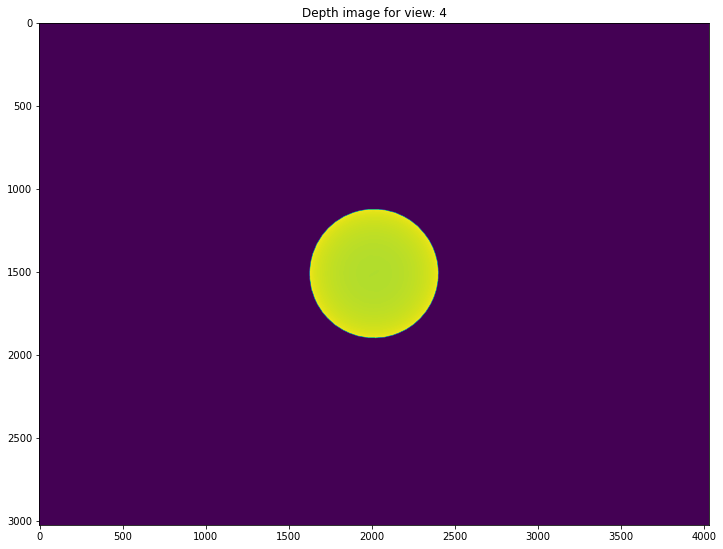

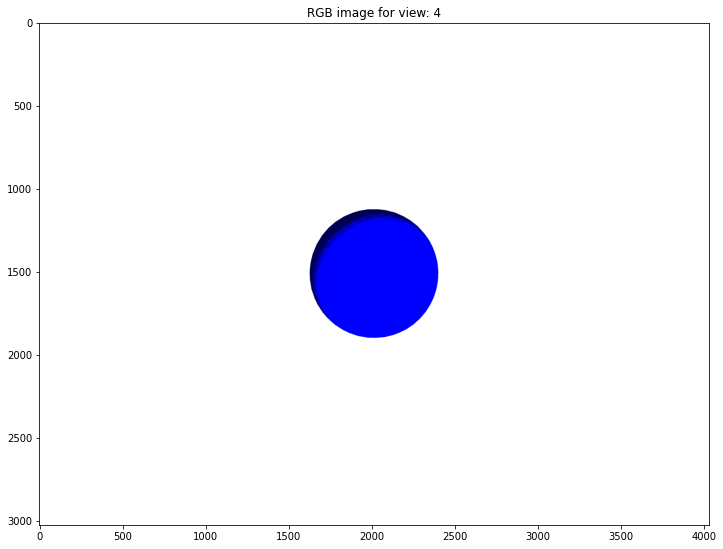

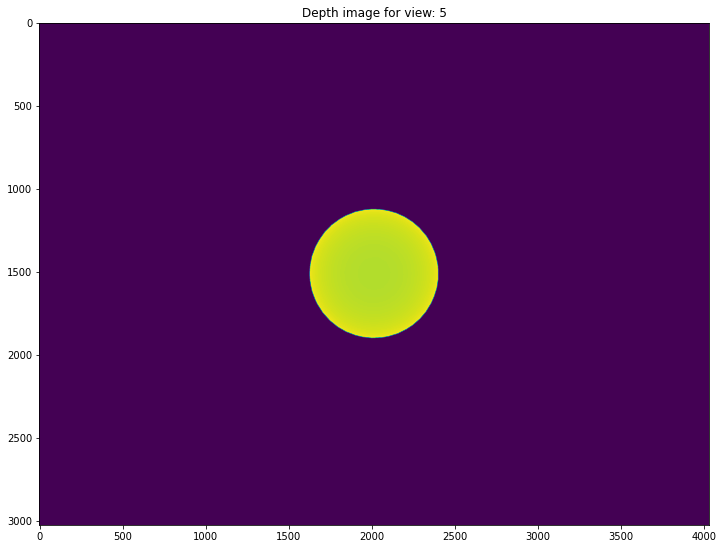

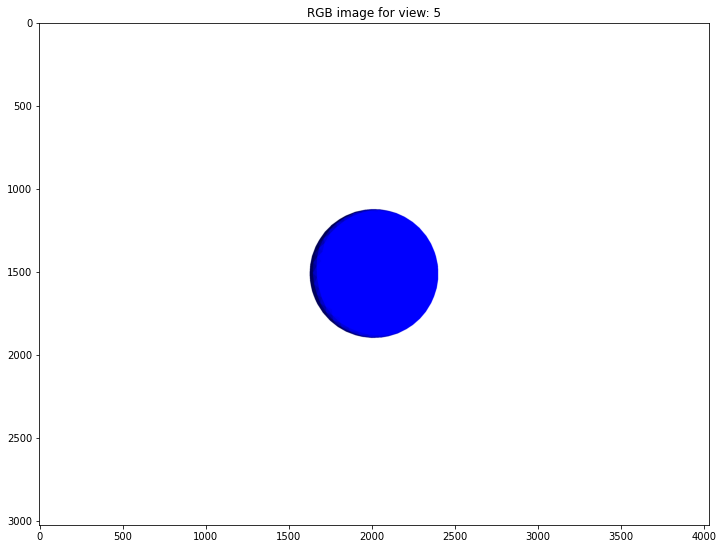

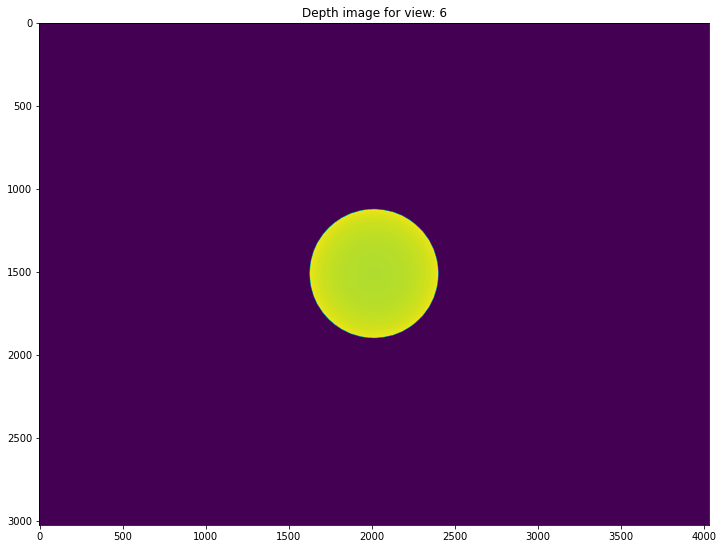

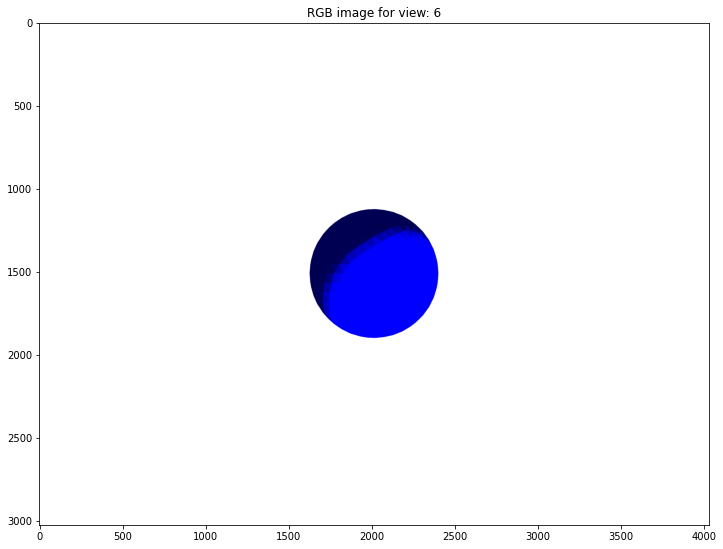

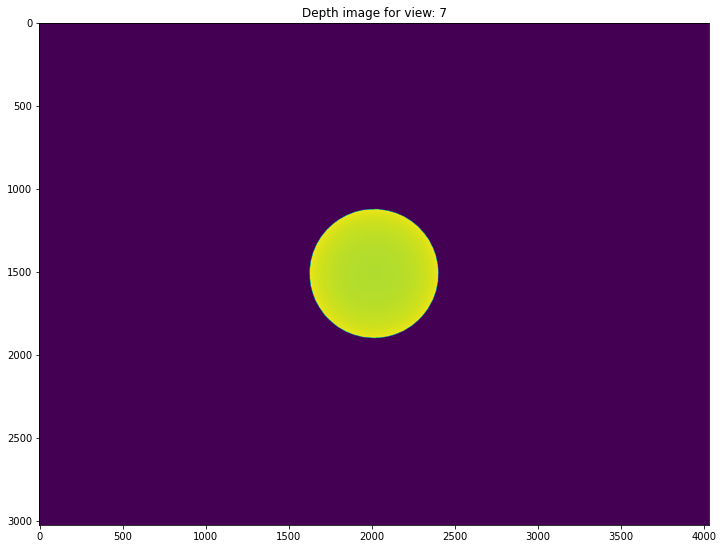

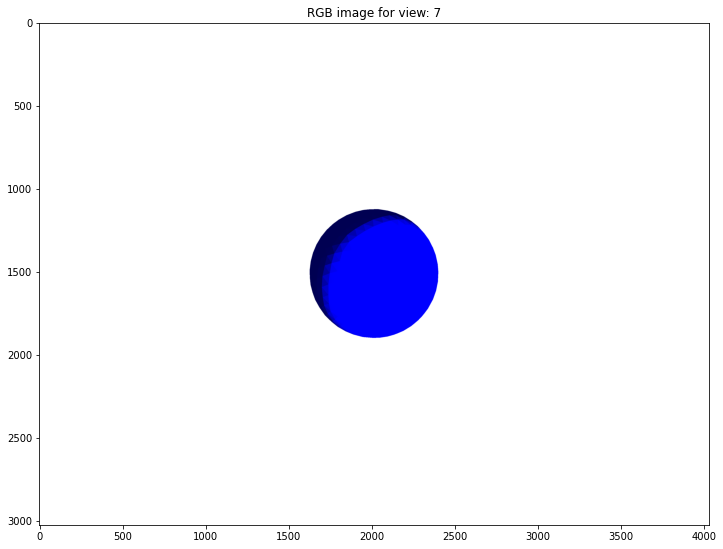

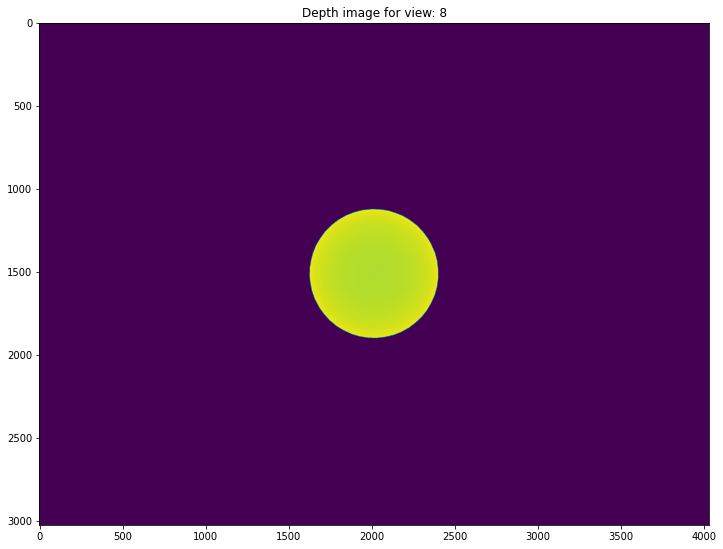

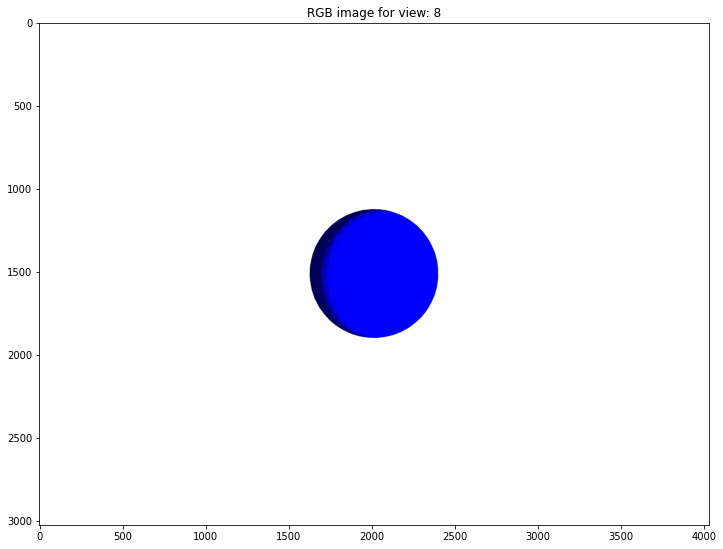

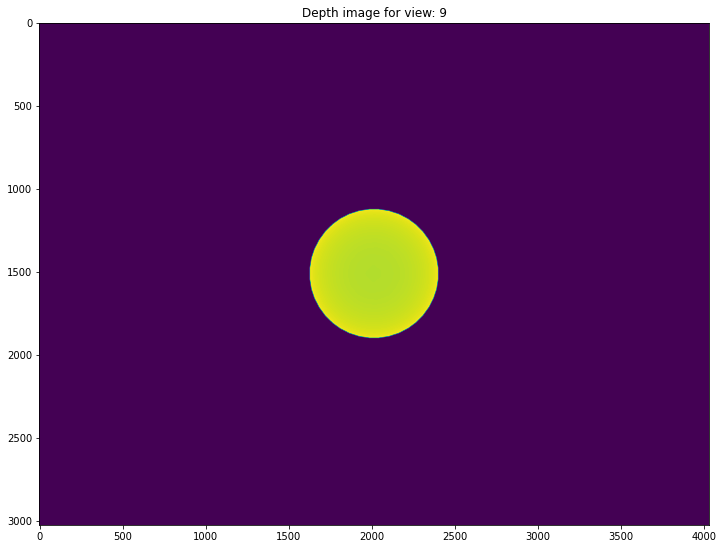

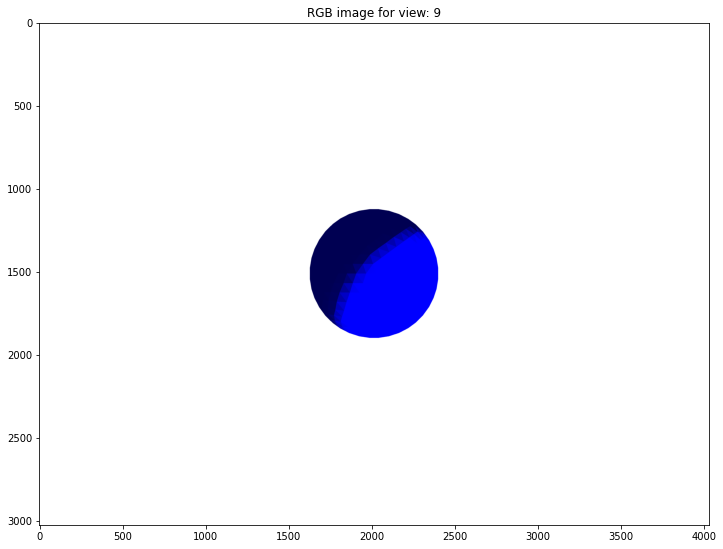

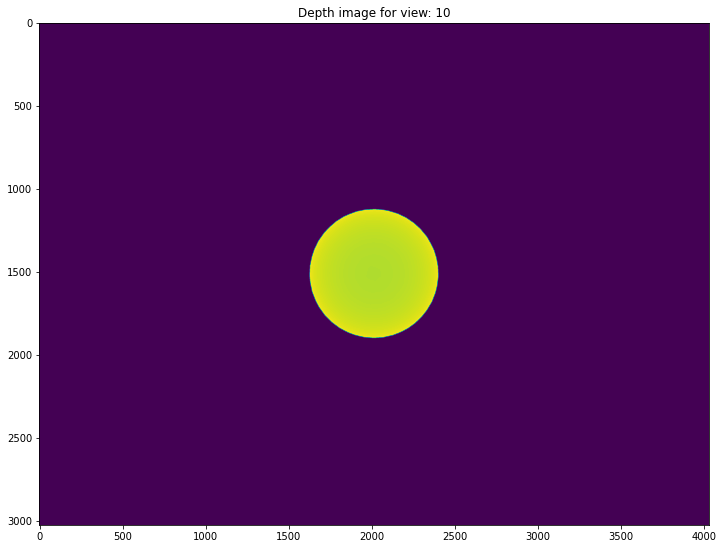

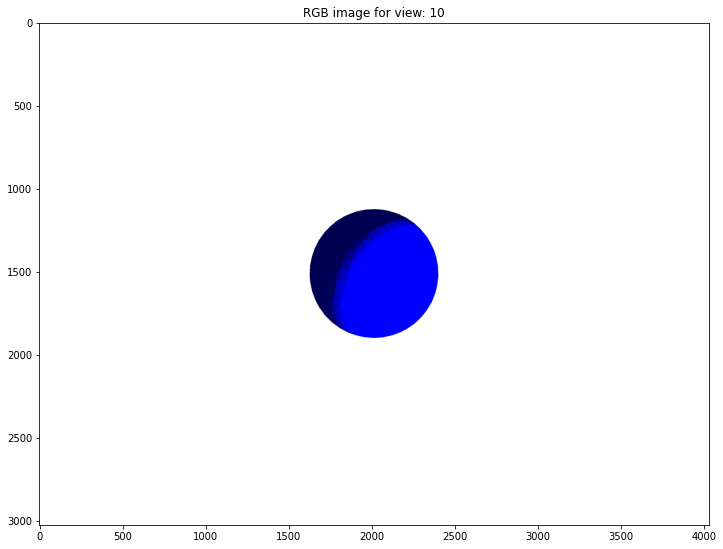

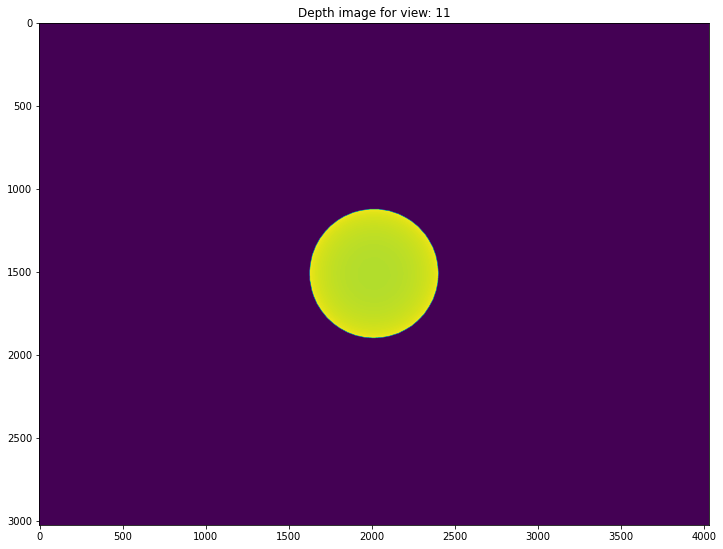

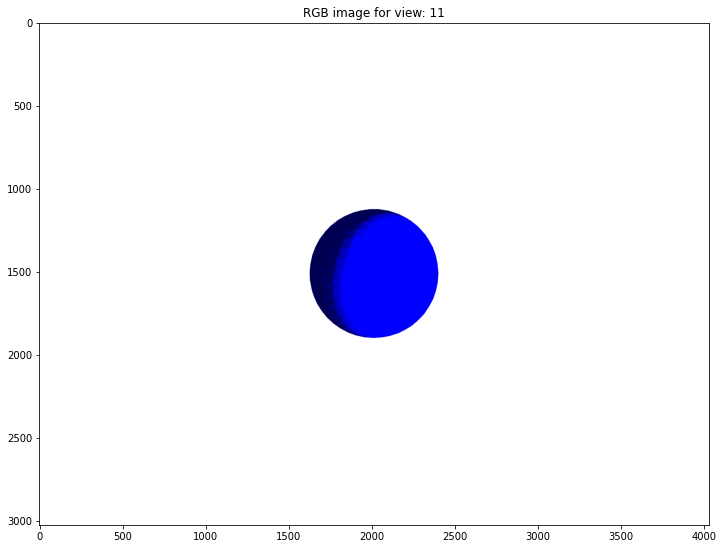

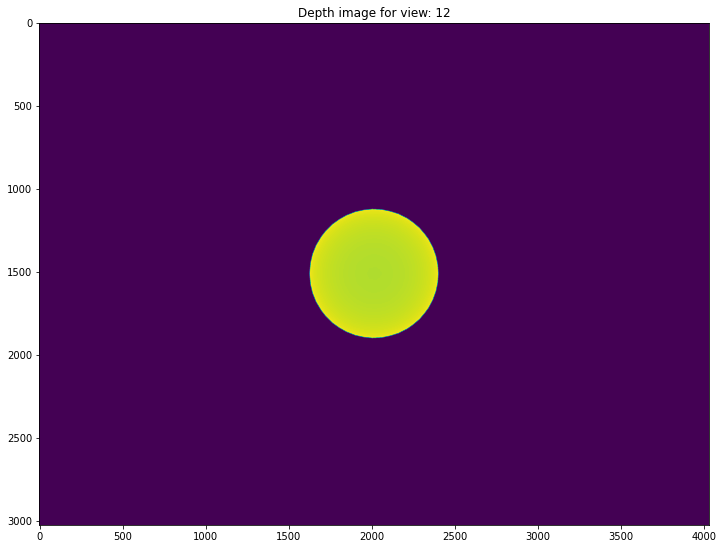

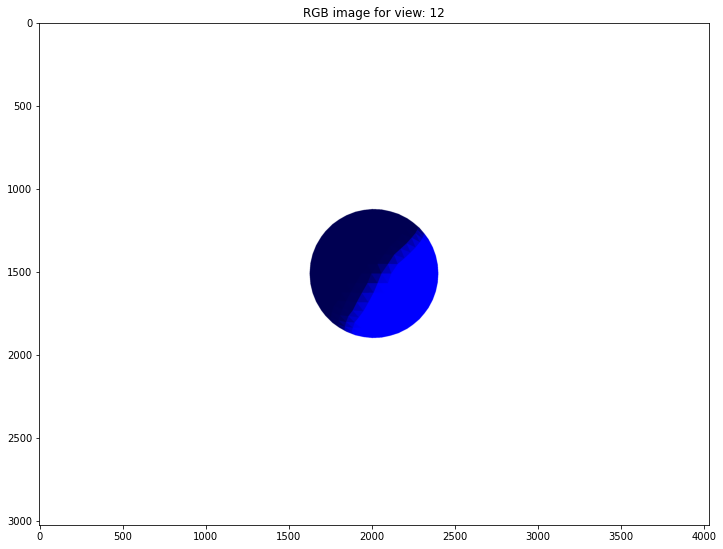

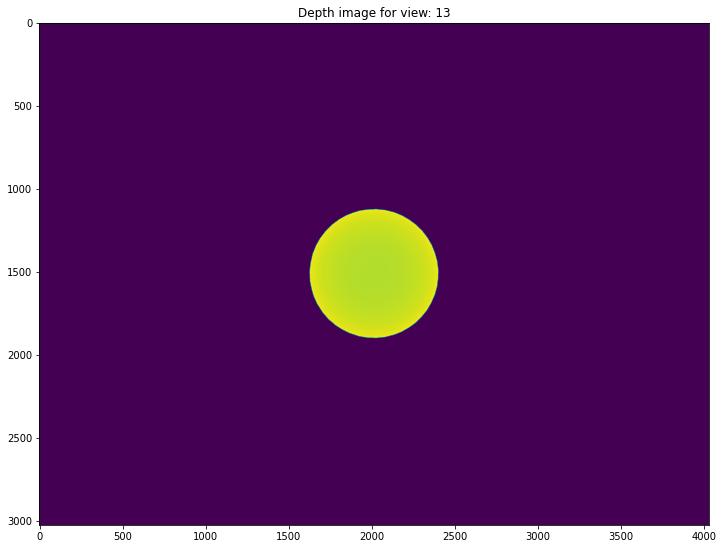

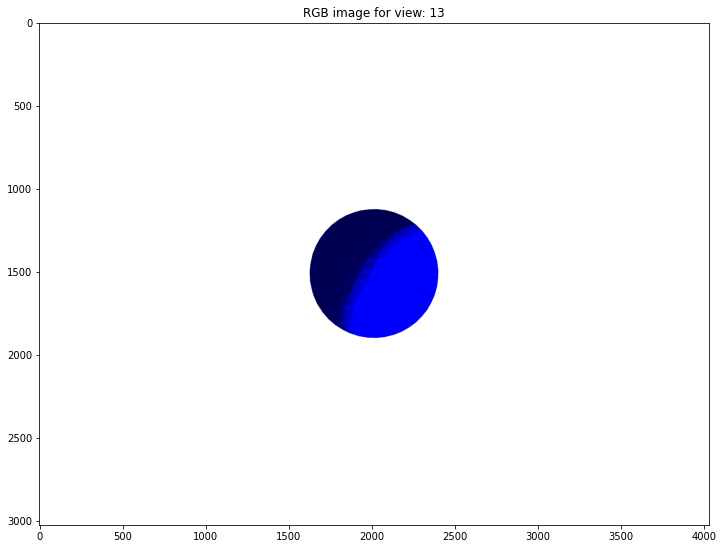

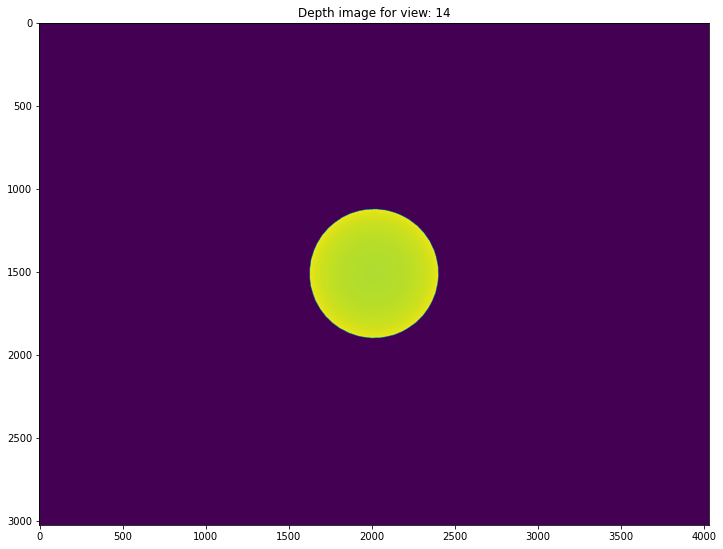

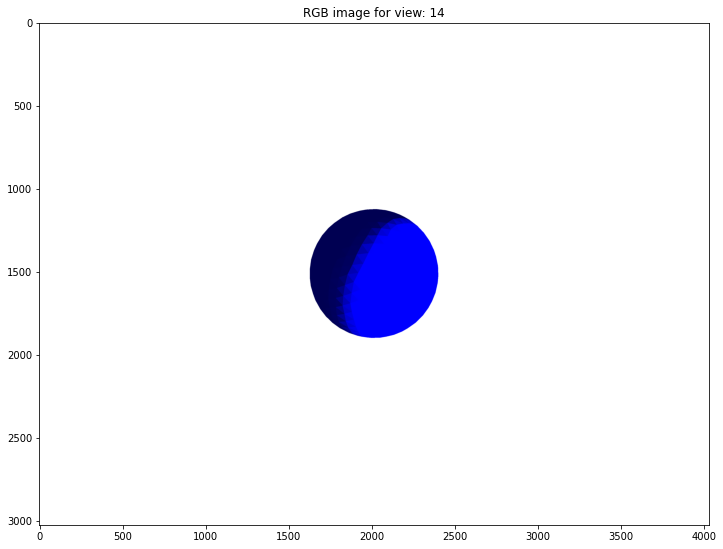

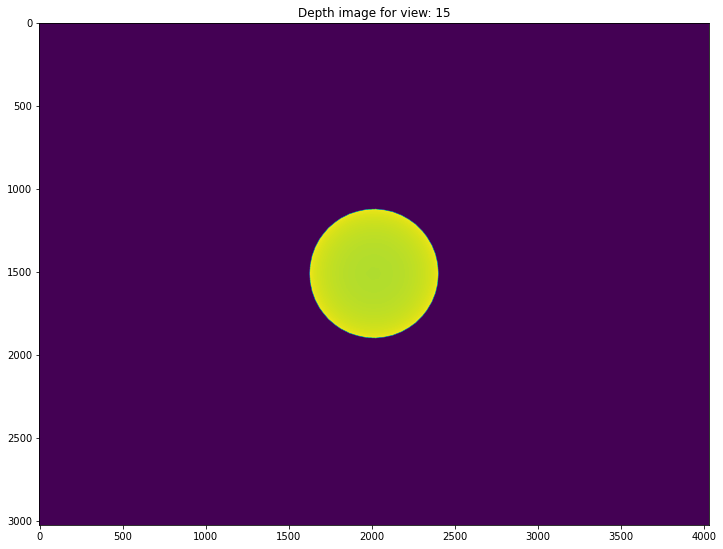

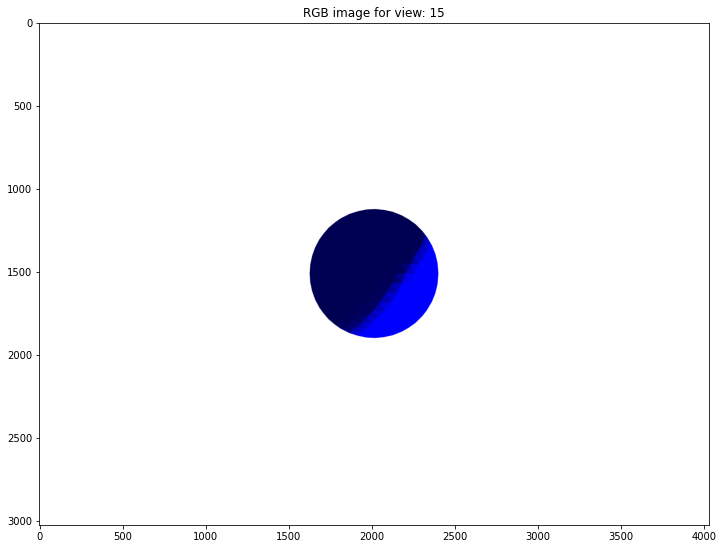

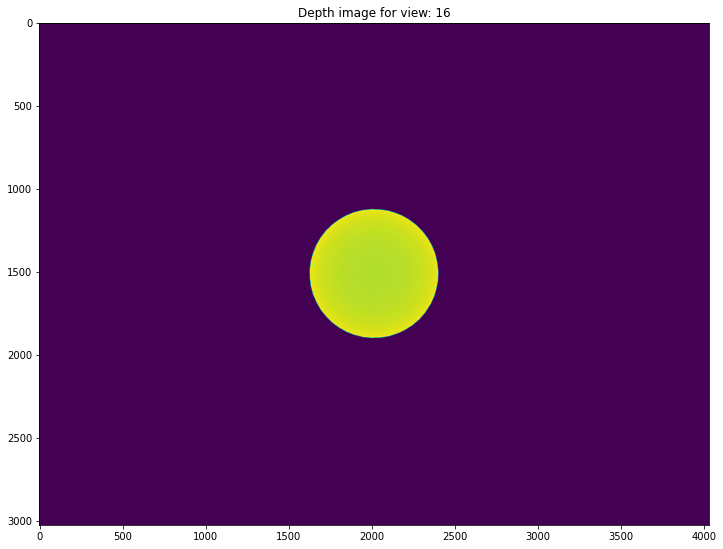

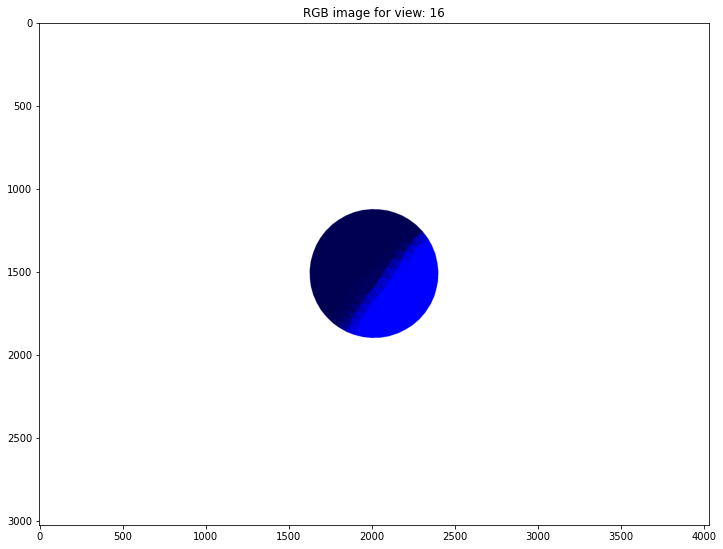

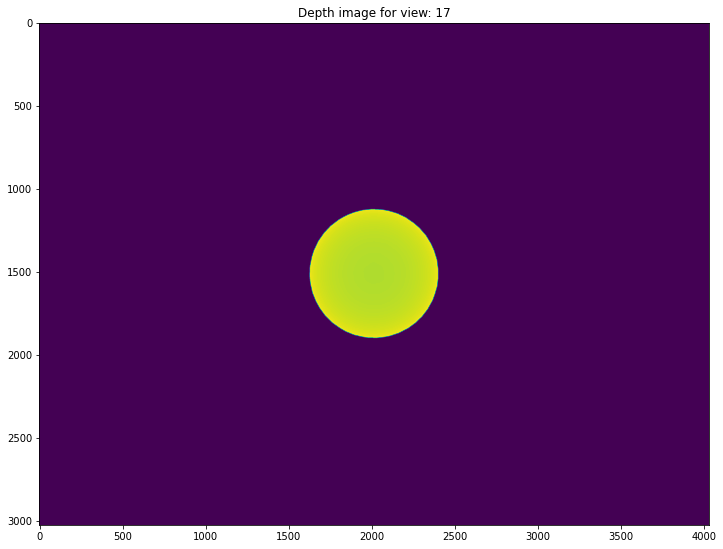

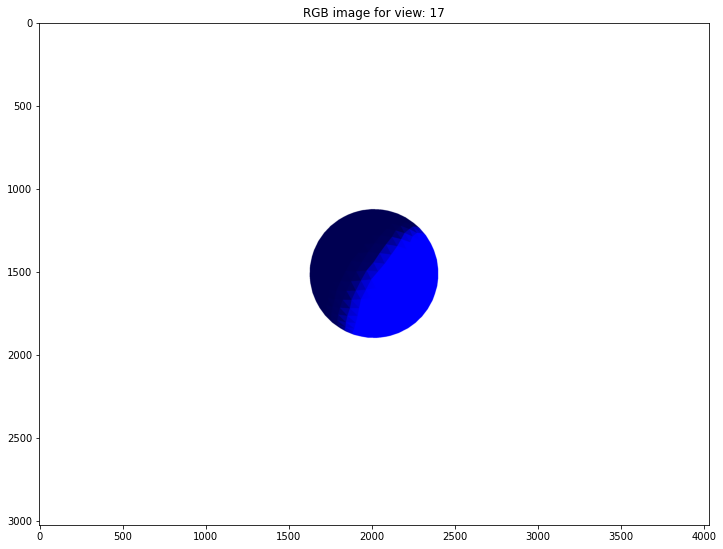

In [67]:
from scipy.spatial.transform import Rotation as R
view_info = {}
VISUALIZE = True

if not os.path.exists(data_save_dir):
    os.makedirs(data_save_dir)
if not os.path.exists(os.path.join(data_save_dir, "depth_images")):
    os.makedirs(os.path.join(data_save_dir, "depth_images"))
    
if not os.path.exists(os.path.join(data_save_dir, "images")):
    os.makedirs(os.path.join(data_save_dir, "images"))
    
spherical_camera_poses_in_origin = get_spherical_poses(radius=0.8)

for number, pose in enumerate(spherical_camera_poses_in_origin): 
    camera_rotation = R.from_matrix(pose[:3, :3])
    camera_pose_info = dict(translation=pose[:3, -1].tolist(), quaternion=camera_rotation.as_quat().tolist())
    view_info[number] = camera_pose_info
    rgb_image, depth_image = get_mesh_img(
        renderer=renderer, 
        pyrender_scene=pyrender_scene, 
        cam_node=cam_node, 
        pose=pose,
    )
    # Saving the depth image
    depth_image_path = os.path.join(data_save_dir, "depth_images", f"image_{number}.npy")
    np.save(arr=depth_image, file=depth_image_path)
    #depth_im = Image.fromarray(depth_image).convert("L")
    #depth_im.save(depth_image_path)
    
    # Saving the rgb image
    rgb_im = Image.fromarray(rgb_image)
    rgb_image_path = os.path.join(data_save_dir, "images", f"image_{number}.png")
    rgb_im.save(rgb_image_path)
    view_info[number]["rgb_image_path"] = rgb_image_path
    view_info[number]["depth_image_path"] = depth_image_path
    view_info[number]["fx"] = fx
    view_info[number]["fy"] = fy
    view_info[number]["cx"] = W / 2
    view_info[number]["cy"] = H / 2
    if VISUALIZE:
        plt.figure(figsize=(12, 12))
        plt.title(f"Depth image for view: {number}")
        plt.imshow(depth_image)
        plt.figure(figsize=(12, 12))
        plt.title(f"RGB image for view: {number}")
        plt.imshow(rgb_image)
    
    
info_save_path = os.path.join(data_save_dir, "scene_info.yaml")
scene_info = {"views": view_info}
with open(info_save_path, 'w') as file:
    yaml.dump(scene_info, file)
    print(f"Saving to {info_save_path}")
    


In [68]:
import os

import numpy as np
import yaml
import imageio

basedir="/scratch/aiscience/data/synthetic/table_with_objects/"
recentered_camera_poses_in_world = np.load(
    os.path.join(basedir, "recentered_camera_poses_in_world.npy")
)
bds = np.load(
    os.path.join(basedir, "bds.npy")
)

def load_dense_depth(
    basedir=basedir,
    bds=bds,
    factor=1,
    bd_factor=0.75,
    recentered_camera_poses_in_world=recentered_camera_poses_in_world,
    render_using_mesh=False,
):
    """

    Args:
        basedir: The directory containing colmap data of the scene.
        bds: Bounds of the scene. 
        factor: Factor by which the original images are resized.
        bd_factor: Factor by which the bounds of the scene are chopped of by.
        recentered_camera_poses_in_world: The poses of the cameras after recentering and scene resizing. 
        render_using_mesh: Render the depth using the mesh of the scene.
            If False, the "depth_images" folder must be populated with the depth data.
    """
    if render_using_mesh:
        raise NotImplementedError("Rendering using the mesh isn't implemented yet. need camera intrinsics and other info to be used with pyrender.")
    
    with open(os.path.join(basedir, "scene_info.yaml")) as scene_info_file:
        view_info = yaml.load(scene_info_file, Loader=yaml.FullLoader)
    
    for view in view_info["views"]:
         depth = imageio.imread(view_info["views"][view]["depth_image_path"])
         print((depth))

load_dense_depth()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/aiscience/data/synthetic/table_with_objects/recentered_camera_poses_in_world.npy'

In [114]:

import numpy as np

In [115]:
points_in_world_3 = np.load("all_points.npy")
points_in_world = points_in_world_3

In [116]:
points_in_world.shape

(7, 378, 504, 3)

In [117]:
!pip3 install dash

     |████████████████████████████████| 7.4 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 37.1 MB/s eta 0:00:01
     |████████████████████████████████| 357 kB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 63.6 MB/s eta 0:00:01
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3803 sha256=ffe23438b43a63124016f857a75c4c4e9b3ca28b43cbefef8582de6e17bafb68
  Stored in directory: /tmp/pip-ephem-wheel-cache-2smt8e0k/wheels/52/e4/f3/16724791571a955a46d54650510c98c04ab7d339626aee27cc
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4071 sha256=7e10e1c57692d8719a39bb7e661e05e0a9439c98fbb9f711a508453a00ad2fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2smt8e0k/wheels/73/d8/8d/92f612c03c895f19bcc56a6c54be7bb41aaa698012a5624f60
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3897 sha256=5cd796420bf11b0409c466a12903b

In [119]:
points = None
for image_id in range(points_in_world.shape[0]):
    current_points = np.reshape(
        points_in_world[image_id], 
        (points_in_world[image_id].shape[0] * points_in_world[image_id].shape[1], 3)
    )
    if points is not None:
        points = np.vstack((points, current_points))
    else:
        points = current_points
    
print(points.shape)


(1333584, 3)


In [120]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import plotly

num_points = 5000
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:, 0].tolist(), 
            y=points[:, 1].tolist(), 
            z=points[:, 2].tolist(),
            mode="markers"
        )
    ]
)
# import dash
# import dash_core_components as dcc
# import dash_html_components as html

#app = dash.Dash()
#app.layout = html.Div([
#    dcc.Graph(figure=fig)
#])

#app.run_server(debug=True, use_reloader=False)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plotly.offline.plot(fig, filename = 'filename.html', auto_open=False)

KeyboardInterrupt: 

In [ ]:
fig.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(points.shape)
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

In [ ]:
points_in_world[0].shape[0]

In [ ]:
points_in_world[0]

In [ ]:
a = np.load("pts_cam_3.npy")

In [ ]:
print(a)

In [ ]:
a.shape

In [ ]:
current_points = np.reshape(a, (a.shape[0] * a.shape[1], 3))

current_points = current_points[~np.isnan(current_points).any(axis=1), :]

In [ ]:
current_points.shape
np.max(current_points[:, -1])

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(current_points[:, 0], current_points[:, 1], current_points[:, 2])

In [ ]:
current_points.shape


In [ ]:
np.median(current_points[:, -1])

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame({
 'x':current_points[:, 0].tolist(), 'y':current_points[:, 1].tolist(), 'z':current_points[:, 2].tolist()
})
fig = px.scatter_3d(df, x='x', y='y',z='z',
               size_max=18,
               opacity=0.7)

fig.show()

In [27]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [42]:
pts_2 = o3d.io.read_point_cloud("all_pts_full.ply")

In [43]:
points_2 = np.array(pts_2.points)

In [44]:
pts_num, _ = points_2.shape

In [ ]:

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points_2[:pts_num//4, 0].tolist(), 
            y=points_2[:pts_num//4, 1].tolist(), 
            z=points_2[:pts_num//4, 2].tolist(),
            mode="markers"
        )
    ]
)
# import dash
# import dash_core_components as dcc
# import dash_html_components as html

#app = dash.Dash()
#app.layout = html.Div([
#    dcc.Graph(figure=fig)
#])

#app.run_server(debug=True, use_reloader=False)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size = 1)
plotly.offline.plot(fig, filename = 'filename.html', auto_open=False)

In [41]:
fig.show()
